In [61]:
import os
import json
import sqlite3
import pandas as pd
import datetime
import decimal
import matplotlib.pyplot as plt
import numpy as np

In [51]:
all_events = []
for root,directories, files in os.walk('../nni'):
    for file in files:
        file_name = '{}/{}'.format(root,file)
        meta_data = file_name.split('/')
        experiment_id = meta_data[3]
        if 'log' in file_name or 'run.sh' in file_name or 'stderr' in file_name:
            continue
        if 'sqlite' in file_name:
                try:
                    conn = sqlite3.connect(file_name)
                    c = conn.cursor()
                    c.execute('SELECT * FROM TrialJobEvent')
                    result = c.fetchall()
                    all_events+=[{'time_point':  datetime.datetime.fromtimestamp(i[0]/1000),
                                  'experiment_id': experiment_id,
                                  'trial_id': i[1],
                                  'type': i[2],
                                  'queue': json.loads(i[3])['parameter_id'] if i[3] else None,
                                  'batch': json.loads(i[3])['parameters']['batch'] if i[3] else None,
                                  'lr': json.loads(i[3])['parameters']['lr'] if i[3] else None,
                                  'hidden_factors': json.loads(i[3])['parameters']['hidden_factors'] if i[3] else None,
                                  'regularizer': json.loads(i[3])['parameters']['regularizer'] if i[3] else None,
                                 } for i in result] 
                finally:
                    conn.close()

In [52]:
all_events_df = pd.DataFrame(all_events)
all_events_df['duration'] = 0

In [53]:
for trial_id, body in all_events_df.groupby('trial_id'):
    begin_time = body[body['type']=='RUNNING']['time_point'].array
    end_time = body[body['type']=='SUCCEEDED']['time_point'].array
    if end_time.size == 0:
        all_events_df = all_events_df[all_events_df['trial_id']!=trial_id]
    else:
        all_events_df.loc[all_events_df['trial_id']==trial_id, 'duration'] = (end_time[0] - begin_time[0]).total_seconds()

In [54]:
all_events_df = all_events_df[all_events_df['type']=='WAITING'].drop(columns=['type'])
all_events_df['value'] = 0
all_events_df['method'] = ''
all_events_df

,time_point,experiment_id,trial_id,queue,batch,lr,hidden_factors,regularizer,duration,value,method
0,2020-07-08 13:16:28.168,dUkizMmG,E8cQ2,0,1024.0,-2.231577,4.0,-7.275629,931.535,0,
2,2020-07-08 13:16:48.204,dUkizMmG,pdLIl,1,512.0,-3.389669,4.0,-7.046253,1529.633,0,
3,2020-07-08 13:16:48.208,dUkizMmG,aLdpt,2,128.0,-2.309056,64.0,-4.018720,5699.736,0,
4,2020-07-08 13:16:48.211,dUkizMmG,Do70f,3,1024.0,-3.554847,32.0,-4.381652,959.034,0,
9,2020-07-08 13:32:12.555,dUkizMmG,qeuCS,4,128.0,-3.910599,8.0,-7.414376,5315.286,0,
...,...,...,...,...,...,...,...,...,...,...,...
972,2020-07-11 22:11:30.222,Rot5r6UM,x8Y9c,25,512.0,-2.148111,8.0,-6.593163,1559.900,0,
975,2020-07-11 22:22:49.718,Rot5r6UM,xS1qZ,26,512.0,-3.838289,8.0,-4.633498,1545.701,0,
978,2020-07-11 22:27:21.329,Rot5r6UM,GLNvh,27,1024.0,-3.069631,16.0,-5.827345,943.966,0,
981,2020-07-11 22:37:39.828,Rot5r6UM,Mu83B,28,1024.0,-3.376599,8.0,-7.815021,949.803,0,


In [55]:
with open('experiment_model2.json', 'r') as f:
    data_json = json.loads(f.read())

In [56]:
for k, v in data_json.items():
    for trial in v['trials']:
        if 'trial_job_id' not in trial:
            continue
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'value'] = float(trial['value'])
        all_events_df.loc[all_events_df['trial_id']==trial['trial_job_id'], 'method'] = v['method']

In [57]:
duration_df = pd.DataFrame([{'method': method,
  'duration':sum(data['duration'])
 } for method, data in all_events_df.groupby('method')])

In [58]:
duration_df = duration_df.sort_values(['duration'])

In [59]:
print([i for i in all_events_df['method'].unique()])
print([i for i in all_events_df.columns])

['GPTuner', 'Evolution', 'BatchTuner', 'MetisTuner', 'GridSearch', 'BOHB', 'PBTTuner', 'Hyperband', 'TPE', 'Anneal', 'Random']
['time_point', 'experiment_id', 'trial_id', 'queue', 'batch', 'lr', 'hidden_factors', 'regularizer', 'duration', 'value', 'method']


In [62]:
summary_data = all_events_df[['batch','hidden_factors','regularizer','lr','duration', 'value']].sort_values('value', ascending=False)

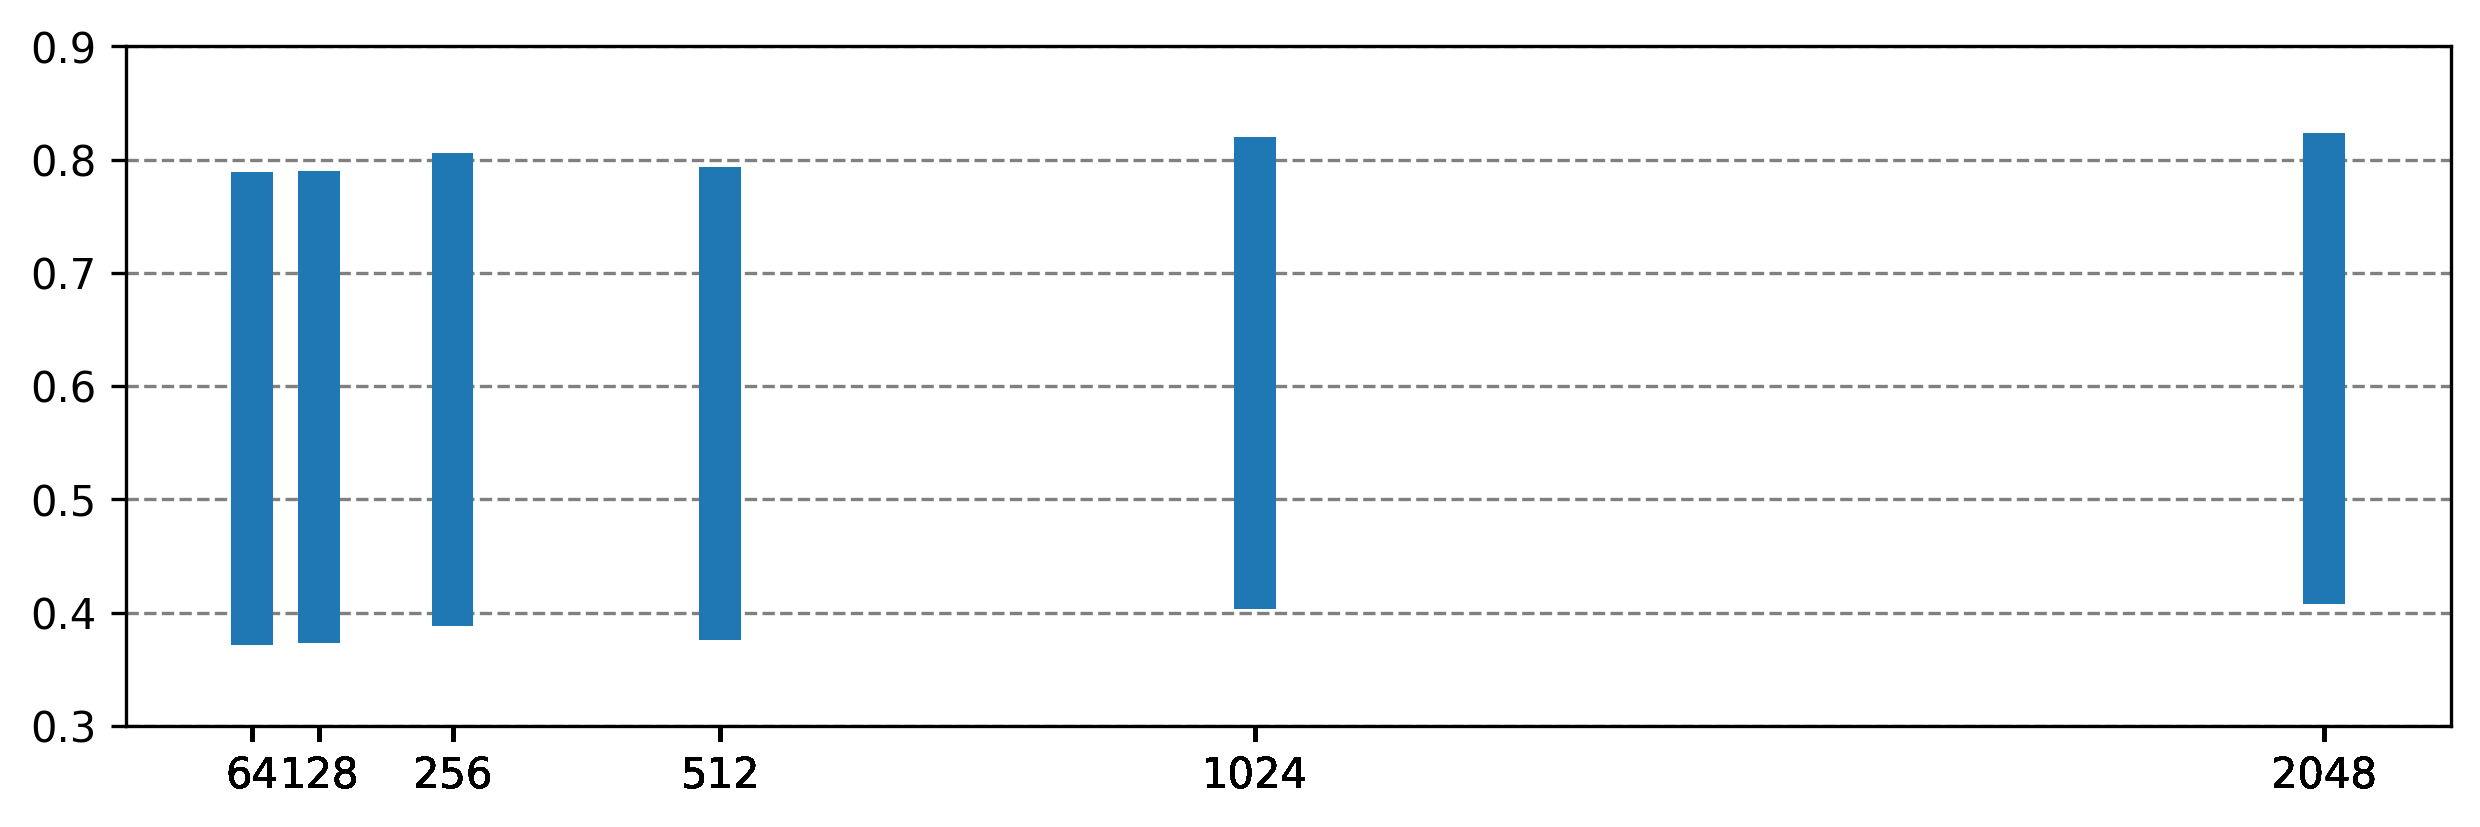

In [85]:
batch_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('batch')]
batch_data = np.array(batch_data)
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0.3,0.9)
plt.bar(batch_data[:,0],batch_data[:,1]/2,bottom=batch_data[:,2]/2, width=40)
plt.xticks(summary_data['batch'])
plt.show()

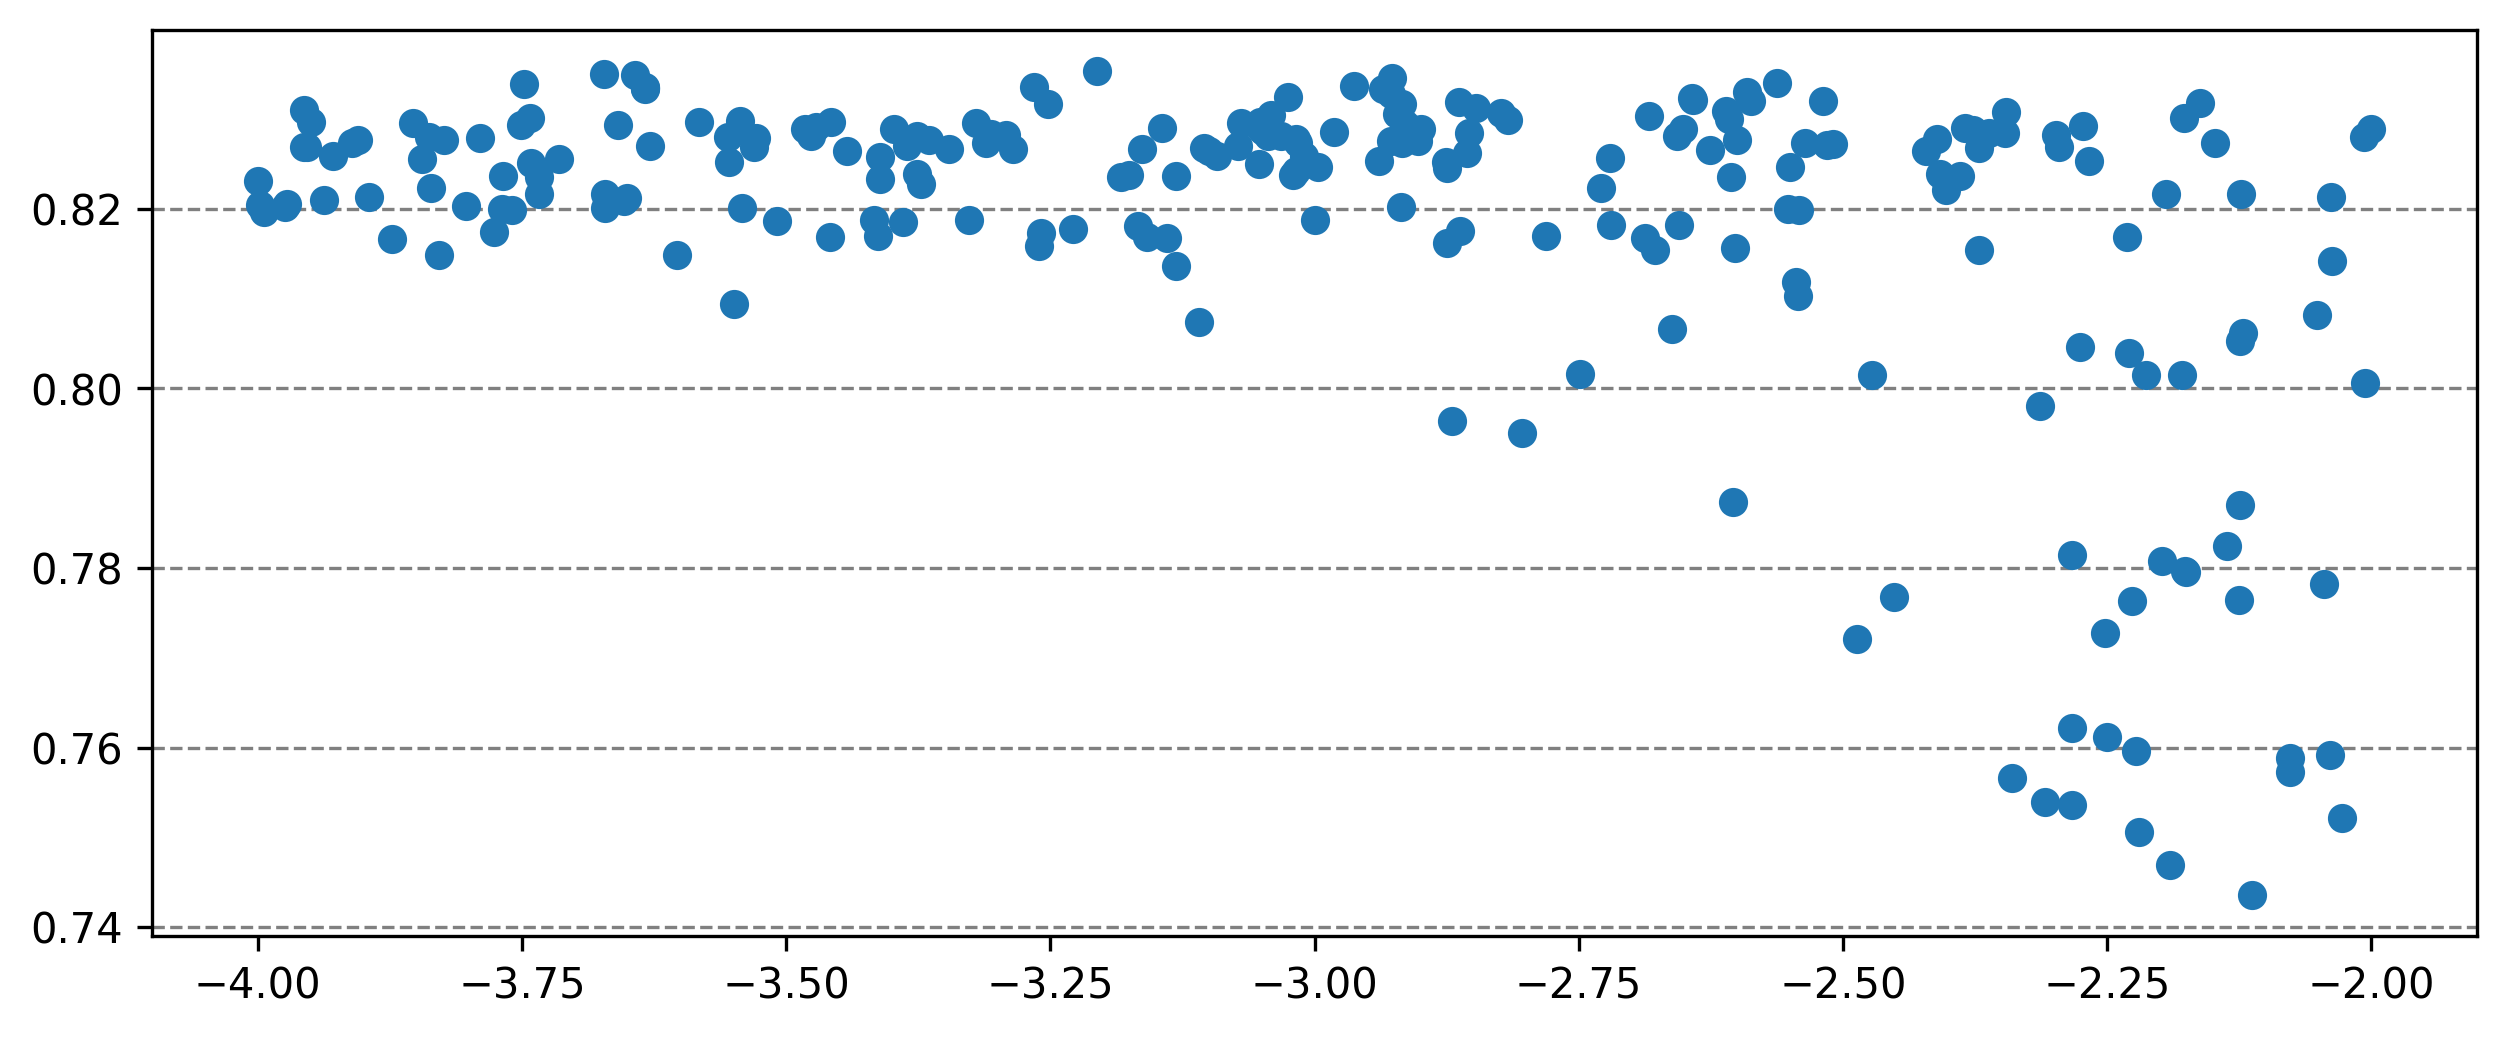

In [73]:
lr_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('lr')]
lr_data = np.array(lr_data)
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.scatter(lr_data[:,0],lr_data[:,1])
plt.show()

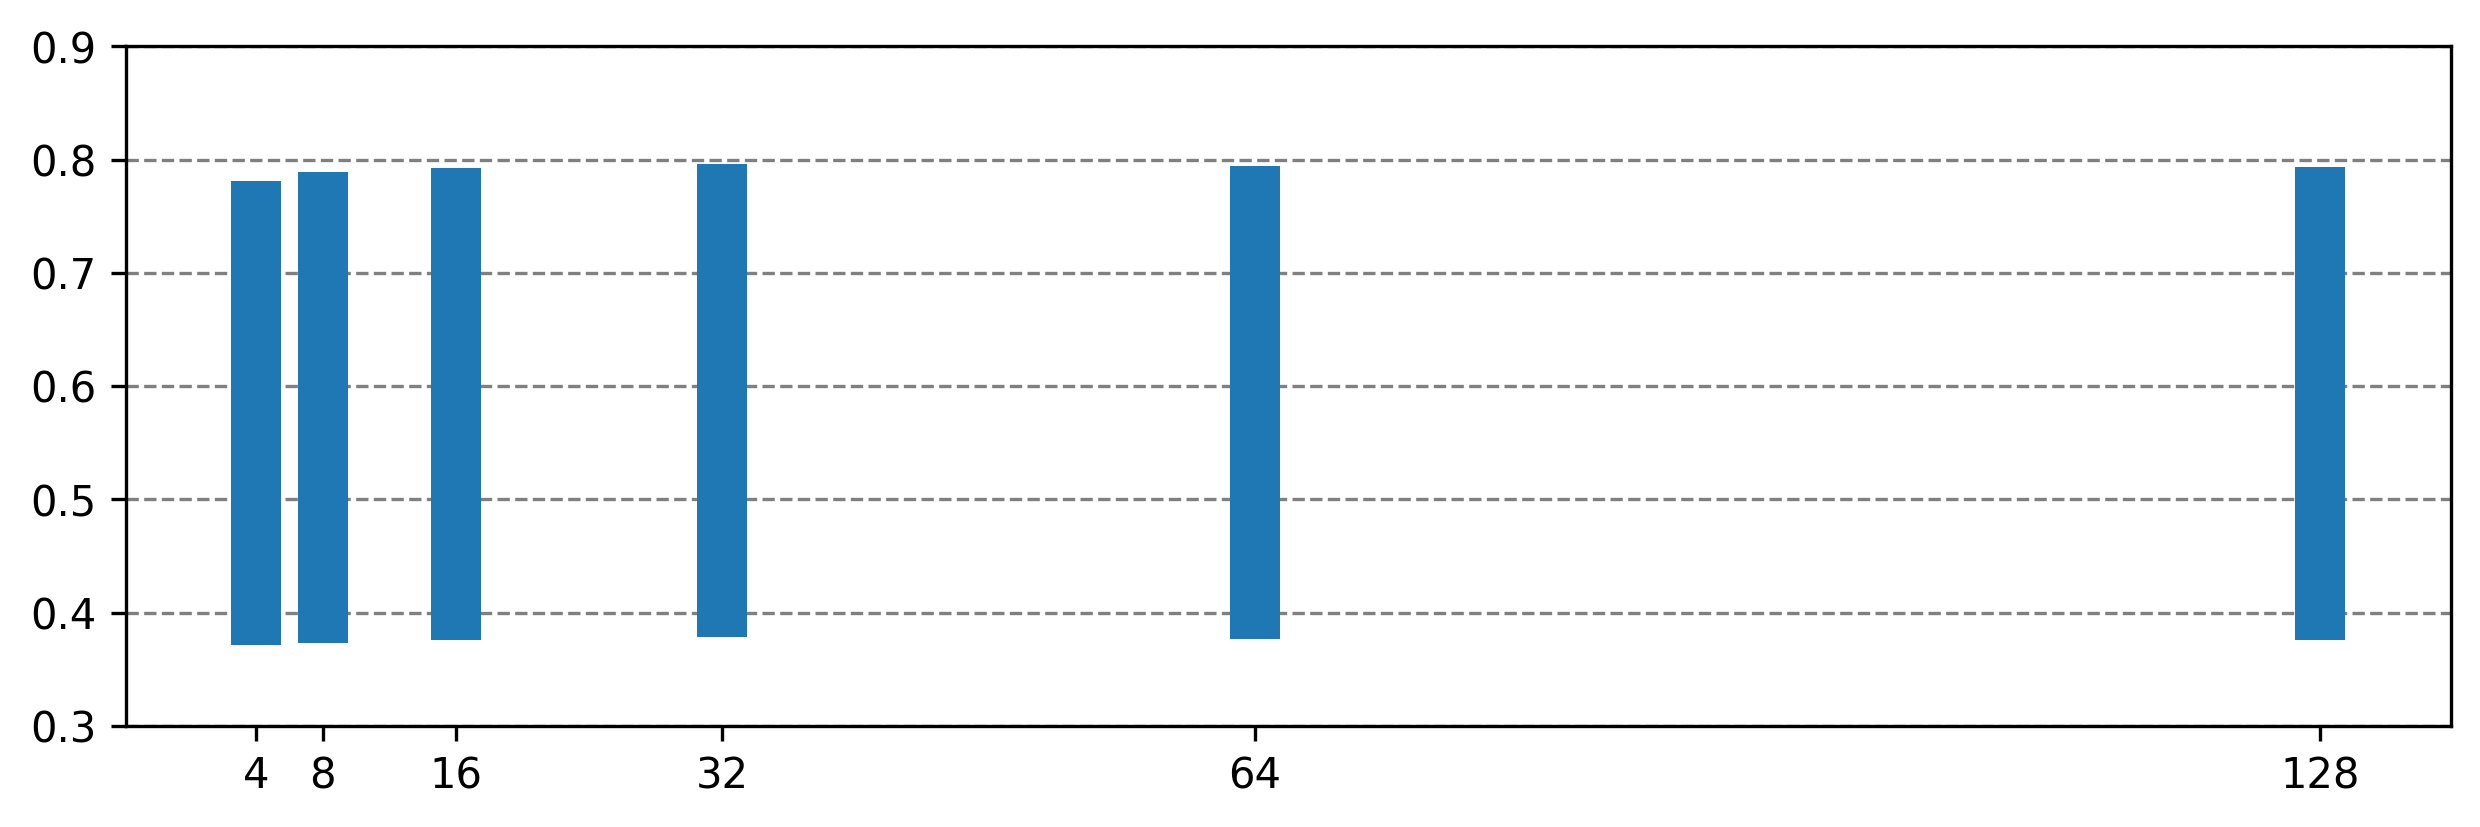

In [86]:
factors_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('hidden_factors')]
factors_data = np.array(factors_data)
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.ylim(0.3,0.9)
plt.bar(factors_data[:,0],factors_data[:,1]/2,bottom=factors_data[:,2]/2, width=3)
plt.xticks(factors_data[:,0])
plt.show()

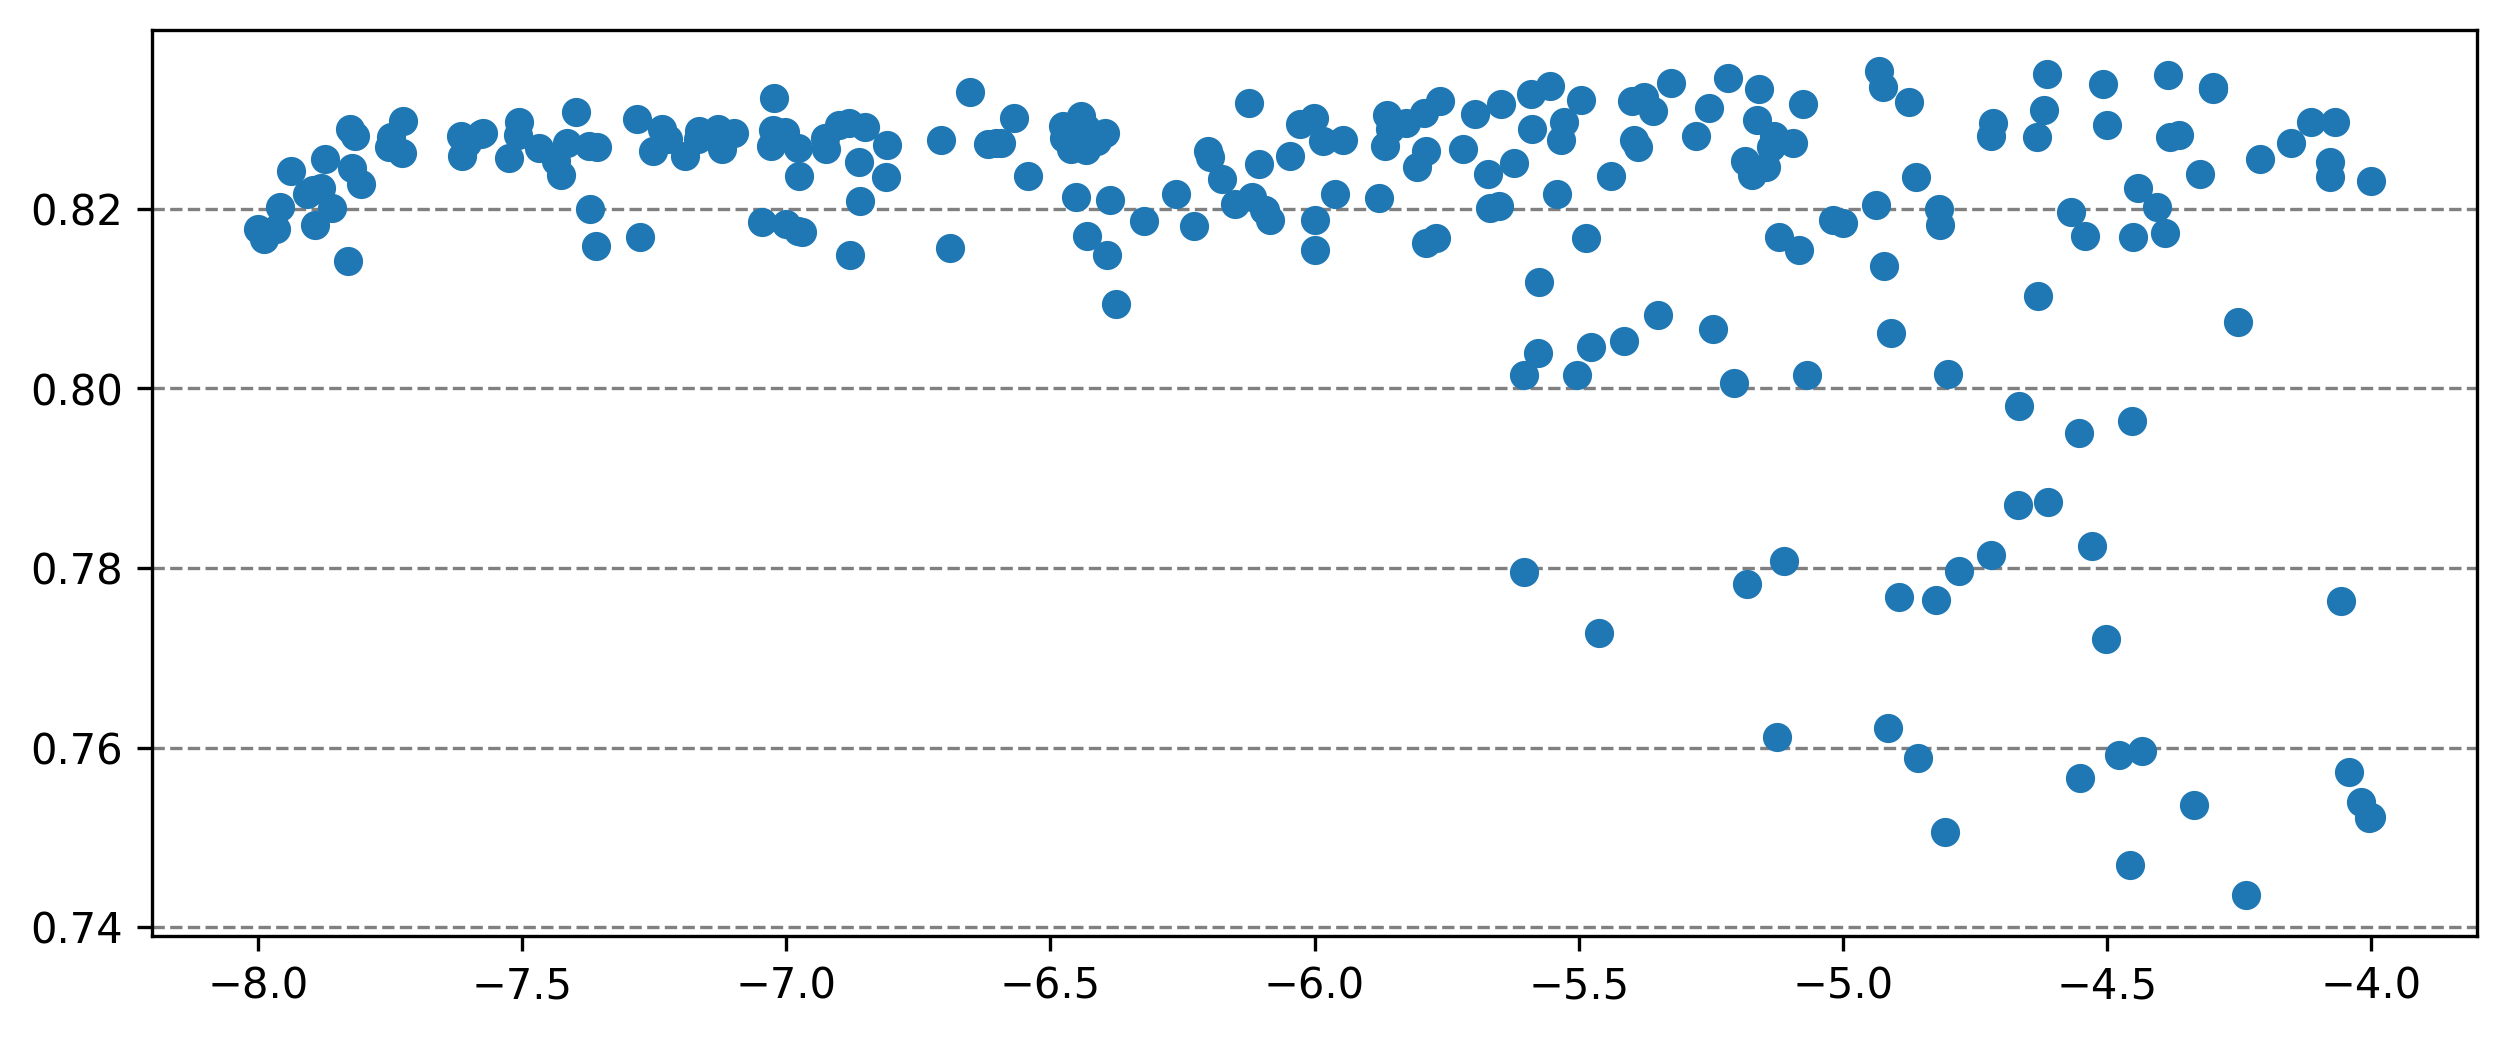

In [87]:
regularizer_data = [[k,v['value'].max(), v['value'].min(), v['duration'].max(), v['duration'].min()] for k, v in summary_data.groupby('regularizer')]
regularizer_data = np.array(regularizer_data)
fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.scatter(regularizer_data[:,0],regularizer_data[:,1])
plt.show()

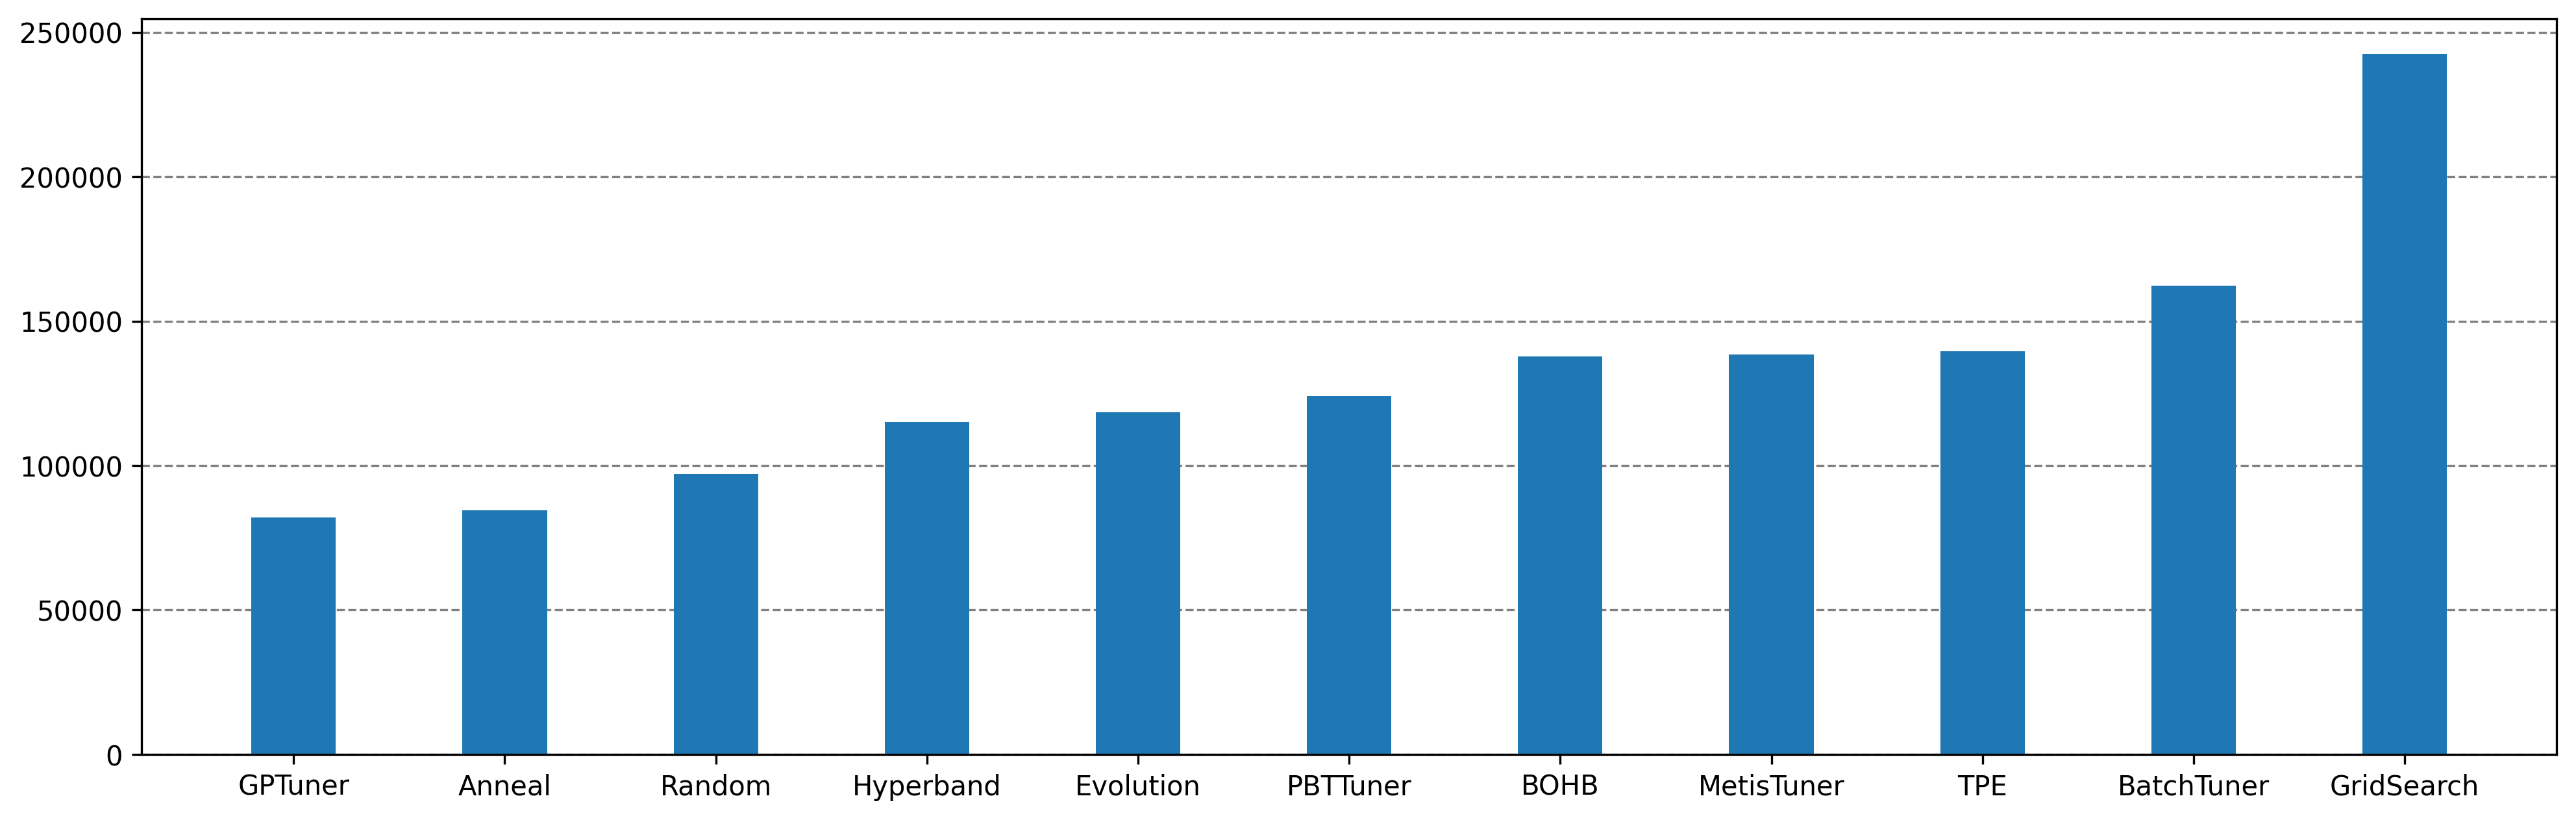

In [46]:
fig, ax = plt.subplots(figsize=(16,5), dpi=300)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
plt.bar(duration_df['method'], duration_df['duration'], width=0.4)
plt.show()

In [47]:
print([i for i in all_events_df['method'].unique()])
print([i for i in all_events_df.columns])

['GPTuner', 'Evolution', 'BatchTuner', 'MetisTuner', 'GridSearch', 'BOHB', 'PBTTuner', 'Hyperband', 'TPE', 'Anneal', 'Random']
['time_point', 'experiment_id', 'trial_id', 'queue', 'batch', 'hidden_factors', 'regularizer', 'duration', 'value', 'method']


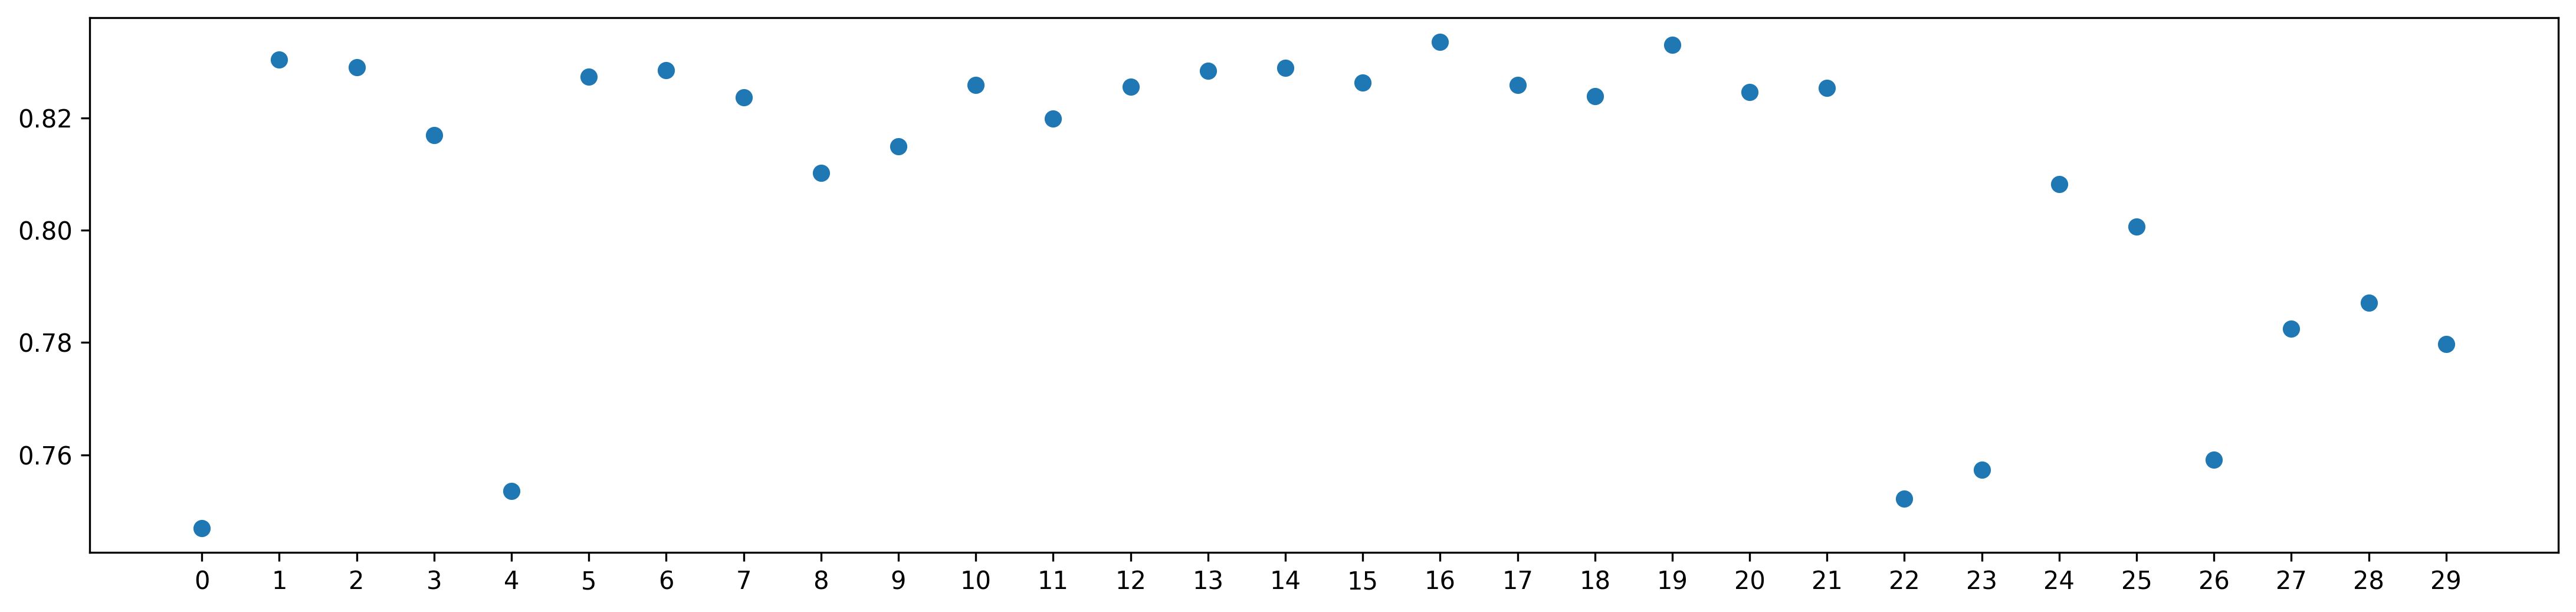

In [48]:
single_method = all_events_df[all_events_df['method']=='TPE']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index)
plt.show()

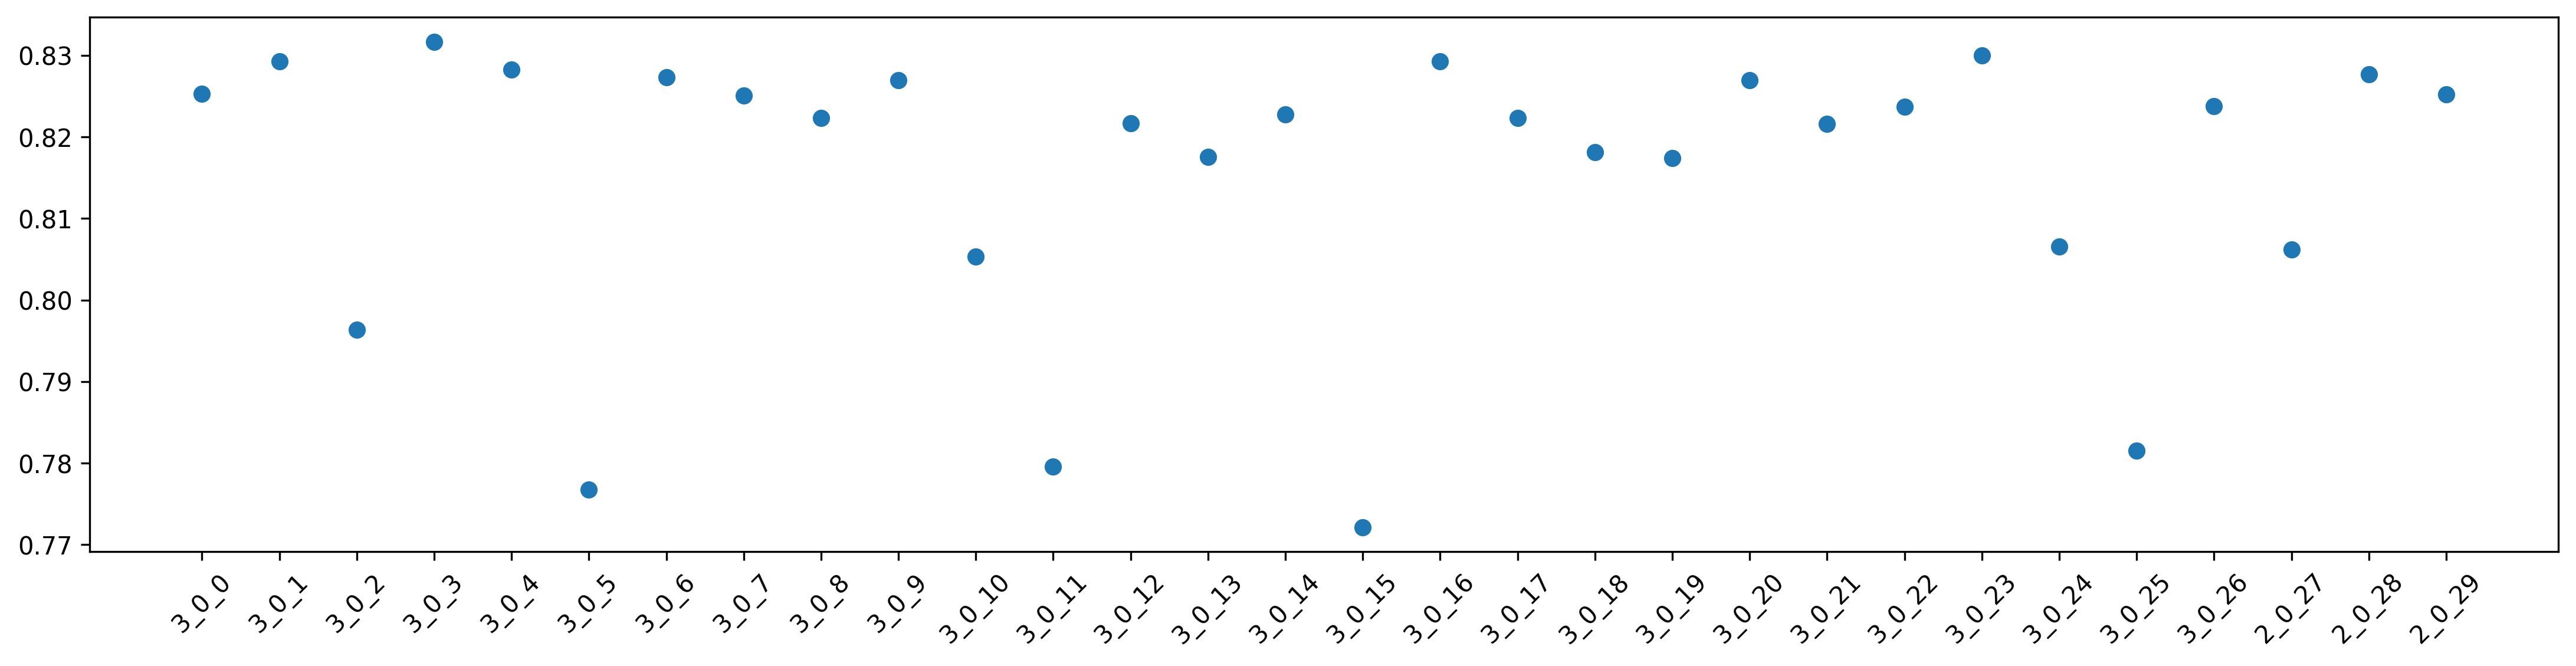

In [49]:
single_method = all_events_df[all_events_df['method']=='Hyperband']
single_method = single_method.set_index('queue')
fig, ax = plt.subplots(figsize=(18,4), dpi=300)
plt.scatter(single_method.index,single_method['value'])
plt.xticks(single_method.index, rotation=45)
plt.show()